In [1]:
import numpy as np
#import Scripts.cifar_resnet as rn
import Scripts.meta_resnet as mrn
import Scripts.wake_processing as wp
import importlib
import Scripts.autoencoder as ae
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
%matplotlib inline
import torch.nn.functional as F

In [2]:
import Scripts.smoothing as smooth

In [3]:
importlib.reload(mrn)
importlib.reload(wp)

<module 'Scripts.wake_processing' from 'E:\\Studies\\Deep Water\\DeepWater\\Scripts\\wake_processing.py'>

## Train function

In [4]:
def train_weights(net, train_data, test_data, num_epochs=5, batch_size=5,  learning_rate=1e-3):
    net = net.to(device)
    opt = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-5)
    criterion = nn.BCELoss(reduction = 'none')
    criterion_mean = nn.BCELoss(reduction = 'mean')
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, num_workers=0, drop_last=True)
    X_val, y_val = test_data.tensors[0].to(device), test_data.tensors[1].to(device)
    train_losses = []
    val_losses = []
    val_accs = []
    train_accs= []
    
    for epoch in range(num_epochs):
        total_loss = []
        batch_accs = []
        for i, (X, y) in enumerate(train_loader):
            net.train()
            X = X.to(device)
            y = y.to(device)
            
            
            meta_net = mrn.ResNet18().to(device)
            meta_net.load_state_dict(net.state_dict())
            # Lines 4 - 5 initial forward pass to compute the initial weighted loss
            
            y_f_hat  = meta_net(X)
            cost = criterion(y_f_hat,y)
            eps = torch.zeros(cost.size()).to(device)
            eps.requires_grad = True
            l_f_meta = torch.sum(cost * eps)
            meta_net.zero_grad()
            
            
             # Line 6 perform a parameter update
            grads = torch.autograd.grad(l_f_meta, (meta_net.parameters()), create_graph=True)
            meta_net.update_params(learning_rate, source_params=grads)

            # Line 8 - 10 2nd forward pass and getting the gradients with respect to epsilon
            y_g_hat = meta_net(tiny_X)

            l_g_meta = criterion_mean(y_g_hat,tiny_y)

            grad_eps = torch.autograd.grad(l_g_meta, eps, only_inputs=True)[0]
            
            # Line 11 computing and normalizing the weights
        
            w_tilde = torch.clamp(-grad_eps,min=0)
            norm_c = torch.sum(w_tilde)

            if norm_c != 0:
                w = w_tilde / norm_c
            else:
                w = w_tilde

            # Lines 12 - 14 computing for the loss with the computed weights
            # and then perform a parameter update
            y_f_hat = net(X)
            cost = criterion(y_f_hat,y)
            l_f = torch.sum(cost * w)

            train_pred_label = 1 - torch.argmax(y_f_hat, dim = 1).cpu().detach().numpy()
            train_true_label = 1 - torch.argmax(y, dim = 1).cpu().detach().numpy()
            batch_acc = accuracy_score(train_true_label, train_pred_label)
            batch_accs.append(batch_acc)
            total_loss.append(torch.mean(cost).cpu().detach().numpy())
            
            opt.zero_grad()
            l_f.backward()
            opt.step()
            
            
        #Checking accuracy/loss
        net.eval()
        
        train_loss = sum(total_loss)/len(total_loss)
        train_acc = sum(batch_accs)/len(batch_accs)
        val_pred = net(X_val)
        val_pred_label = 1 - torch.argmax(val_pred, dim = 1).cpu().detach().numpy()
        val_true_label = 1 - torch.argmax(y_val, dim = 1).cpu().detach().numpy()
        val_loss = criterion_mean(val_pred, y_val).item()
        val_acc = accuracy_score(val_true_label, val_pred_label)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        train_accs.append(train_acc)
        print('Epoch:{}, Loss:{:.4f}, Val Loss:{:.4f}, Train Acc:{:.4f}, Val Acc:{:.4f}'.format(epoch+1, train_loss,
                                                                                           val_loss, train_acc, val_acc))
    return train_losses, val_losses, train_accs, val_accs

In [5]:
def make_plots(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(10,6))
    plt.plot(train_losses, label = 'Train loss')
    plt.plot(val_losses, label = 'Validation loss')
    plt.legend(loc = 'upper left')
    plt.xlabel('Epoch')
    plt.ylabel('Binary Cross-entropy loss')
    plt.show()
    plt.figure(figsize=(10,6))
    plt.plot(train_accs, label = 'Train accuracy')
    plt.plot(val_accs, label = 'Validation accuracy')
    plt.legend(loc = 'upper left')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Reading Data

In [7]:
real_wakes_data = np.load("Data\\Wake data\\confirmed_wakes.npy")
generated_wakes = np.load("Data\\Wake data\\generated_wakes_1000.npy")
not_wakes_day_data = np.load("Data\\Wake data\\negative_samples_3000_day.npy")
not_wakes_all_data = np.load("Data\\Wake data\\negative_samples_3000.npy")
clean_negative_samples = np.load("Data\\Wake data\\clean_negative_samples.npy")
clean_positive_samples  = np.load("Data\\Wake data\\clean_positive_samples.npy")
real_wakes = real_wakes_data[:,:,:-1,:]
not_wakes = not_wakes_day_data[:,:,:-1,:]
not_wakes_all = not_wakes_day_data[:,:,:-1,:]

## The tiny clean validation dataset

In [8]:
tiny_real = clean_positive_samples[:,:,:,:]

In [9]:
tiny_negative = []
for i in [15, 17, 19, 21, 26]:
    tiny_negative.append(clean_negative_samples[i,:,:-1,:])
tiny_negative = np.array(tiny_negative)

In [10]:
tiny_frames = np.append(tiny_real, tiny_negative, axis = 0)
tiny_pos_y = np.concatenate((np.ones(5).reshape(-1,1), np.zeros(5).reshape(-1,1)), axis = 1)
tiny_neg_y = np.concatenate((np.zeros(5).reshape(-1,1), np.ones(5).reshape(-1,1)), axis = 1)
tiny_labels = np.append(tiny_pos_y, tiny_neg_y, axis = 0)

## Hyperparameters

In [11]:
RS = 18
num_epochs = 25

## Reweighting experiment 1

### Training: 500 positive (113 real + 387 generated) and 500 negative 
### Test: 75 positive (29 real + 46 generated) and 75 negative
### Hypervalidation: 5 real + 5 negative (hand-picked)

In [12]:
train_real, test_real = train_test_split(real_wakes, test_size=0.2, random_state=RS)
train_gen, test_gen = train_test_split(generated_wakes, train_size = 0.387, test_size=0.046, random_state=RS)
train_neg, test_neg = train_test_split(not_wakes, train_size = 1/6, test_size = 75/3000, random_state = RS)


In [13]:
test_pos = np.append(test_real, test_gen, axis = 0)
train_pos = np.append(train_real, train_gen, axis = 0)
test_x = np.append(test_pos, test_neg, axis = 0)
train_x = np.append(train_pos, train_neg, axis = 0)
test_pos_y = np.concatenate((np.ones(test_pos.shape[0]).reshape(-1,1), np.zeros(test_pos.shape[0]).reshape(-1,1)), axis = 1)
test_neg_y = np.concatenate((np.zeros(test_neg.shape[0]).reshape(-1,1), np.ones(test_neg.shape[0]).reshape(-1,1)), axis = 1)
train_pos_y = np.concatenate((np.ones(train_pos.shape[0]).reshape(-1,1), np.zeros(train_pos.shape[0]).reshape(-1,1)), axis = 1)
train_neg_y = np.concatenate((np.zeros(train_neg.shape[0]).reshape(-1,1), np.ones(train_neg.shape[0]).reshape(-1,1)), axis = 1)
test_y = np.append(test_pos_y, test_neg_y, axis = 0)
test_y_exp_1 = test_y
test_x_exp_1 = test_x
train_y = np.append(train_pos_y, train_neg_y, axis = 0)

In [14]:
train_dataset = TensorDataset(torch.Tensor(train_x), torch.Tensor(train_y))
test_dataset = TensorDataset(torch.Tensor(test_x), torch.Tensor(test_y))

In [15]:
tiny_X = torch.tensor(tiny_frames).float().to(device)
tiny_y = torch.tensor(tiny_labels).float().to(device)

In [16]:
resnet_1 = None
resnet_1 = mrn.ResNet18()
#train_losses, val_losses, train_accs, val_accs = train_weights(resnet_1, train_dataset, test_dataset, num_epochs = num_epochs, learning_rate=1e-4)
results_1 = train_weights(resnet_1, train_dataset, test_dataset, num_epochs = num_epochs, learning_rate=1e-4)

Epoch:1, Loss:0.3668, Val Loss:0.4762, Train Acc:0.8540, Val Acc:0.8533
Epoch:2, Loss:0.3168, Val Loss:0.3164, Train Acc:0.8860, Val Acc:0.8867
Epoch:3, Loss:0.2522, Val Loss:0.2505, Train Acc:0.9090, Val Acc:0.9067
Epoch:4, Loss:0.2534, Val Loss:0.2332, Train Acc:0.9100, Val Acc:0.9067
Epoch:5, Loss:0.2290, Val Loss:0.3718, Train Acc:0.9230, Val Acc:0.8600
Epoch:6, Loss:0.1958, Val Loss:0.3910, Train Acc:0.9340, Val Acc:0.9000
Epoch:7, Loss:0.1978, Val Loss:0.4068, Train Acc:0.9360, Val Acc:0.8933
Epoch:8, Loss:0.1626, Val Loss:0.3121, Train Acc:0.9540, Val Acc:0.9200
Epoch:9, Loss:0.1832, Val Loss:0.2729, Train Acc:0.9440, Val Acc:0.8733
Epoch:10, Loss:0.1830, Val Loss:0.3826, Train Acc:0.9400, Val Acc:0.8733
Epoch:11, Loss:0.1624, Val Loss:0.4905, Train Acc:0.9460, Val Acc:0.8467
Epoch:12, Loss:0.1294, Val Loss:0.5096, Train Acc:0.9600, Val Acc:0.8733
Epoch:13, Loss:0.1453, Val Loss:0.2679, Train Acc:0.9570, Val Acc:0.9067
Epoch:14, Loss:0.1450, Val Loss:0.3765, Train Acc:0.9470, Va

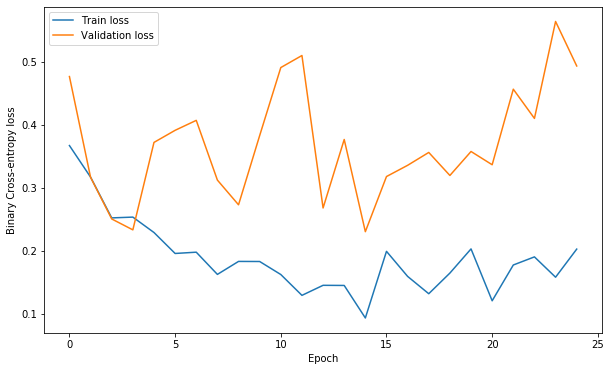

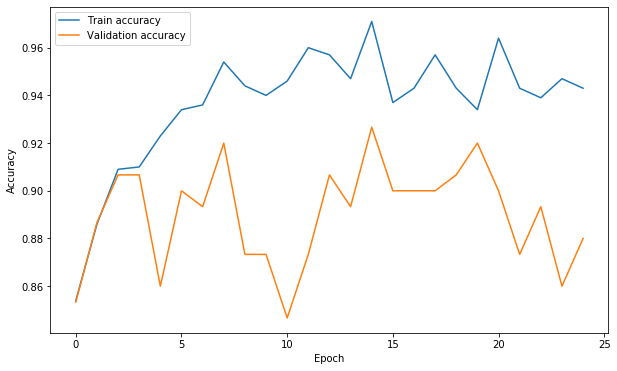

In [17]:
make_plots(results_1[0], results_1[1], results_1[2], results_1[3])

## Reweighting experiment 2

### Training: 200 positive (113 real + 87 generated) and 800 negative 
### Test: 75 positive (29 real + 46 generated) and 75 negative
### Hypervalidation: 5 real + 5 negative (hand-picked)

In [18]:
train_real, test_real = train_test_split(real_wakes, test_size=0.2, random_state=RS)
train_gen, test_gen = train_test_split(generated_wakes, train_size = 0.087, test_size=0.046, random_state=RS)
train_neg, test_neg = train_test_split(not_wakes, train_size = 800/3000, test_size = 75/3000, random_state = RS)



In [19]:
test_pos = np.append(test_real, test_gen, axis = 0)
train_pos = np.append(train_real, train_gen, axis = 0)
test_x = np.append(test_pos, test_neg, axis = 0)
train_x = np.append(train_pos, train_neg, axis = 0)
test_pos_y = np.concatenate((np.ones(test_pos.shape[0]).reshape(-1,1), np.zeros(test_pos.shape[0]).reshape(-1,1)), axis = 1)
test_neg_y = np.concatenate((np.zeros(test_neg.shape[0]).reshape(-1,1), np.ones(test_neg.shape[0]).reshape(-1,1)), axis = 1)
train_pos_y = np.concatenate((np.ones(train_pos.shape[0]).reshape(-1,1), np.zeros(train_pos.shape[0]).reshape(-1,1)), axis = 1)
train_neg_y = np.concatenate((np.zeros(train_neg.shape[0]).reshape(-1,1), np.ones(train_neg.shape[0]).reshape(-1,1)), axis = 1)
test_y = np.append(test_pos_y, test_neg_y, axis = 0)
test_y_exp_1 = test_y
test_x_exp_1 = test_x
train_y = np.append(train_pos_y, train_neg_y, axis = 0)

In [20]:
train_dataset = TensorDataset(torch.Tensor(train_x), torch.Tensor(train_y))
test_dataset = TensorDataset(torch.Tensor(test_x), torch.Tensor(test_y))

In [21]:
tiny_X = torch.tensor(tiny_frames).float().to(device)
tiny_y = torch.tensor(tiny_labels).float().to(device)

In [22]:
resnet_1 = None
resnet_1 = mrn.ResNet18()
results_2 = train_weights(resnet_1, train_dataset, test_dataset, num_epochs = num_epochs, learning_rate=1e-4)

Epoch:1, Loss:0.4852, Val Loss:0.5154, Train Acc:0.7890, Val Acc:0.7667
Epoch:2, Loss:0.3951, Val Loss:0.3059, Train Acc:0.8300, Val Acc:0.8600
Epoch:3, Loss:0.2444, Val Loss:0.3678, Train Acc:0.9170, Val Acc:0.8333
Epoch:4, Loss:0.2149, Val Loss:0.3155, Train Acc:0.9420, Val Acc:0.8800
Epoch:5, Loss:0.1773, Val Loss:0.2967, Train Acc:0.9530, Val Acc:0.8467
Epoch:6, Loss:0.1378, Val Loss:0.2670, Train Acc:0.9590, Val Acc:0.9000
Epoch:7, Loss:0.1491, Val Loss:0.3089, Train Acc:0.9470, Val Acc:0.9200
Epoch:8, Loss:0.1290, Val Loss:0.2284, Train Acc:0.9570, Val Acc:0.9067
Epoch:9, Loss:0.1275, Val Loss:0.2277, Train Acc:0.9710, Val Acc:0.8800
Epoch:10, Loss:0.1299, Val Loss:0.3673, Train Acc:0.9590, Val Acc:0.8733
Epoch:11, Loss:0.1122, Val Loss:0.3720, Train Acc:0.9630, Val Acc:0.8800
Epoch:12, Loss:0.0785, Val Loss:0.3712, Train Acc:0.9740, Val Acc:0.8667
Epoch:13, Loss:0.0648, Val Loss:0.1596, Train Acc:0.9770, Val Acc:0.9533
Epoch:14, Loss:0.1005, Val Loss:0.3495, Train Acc:0.9670, Va

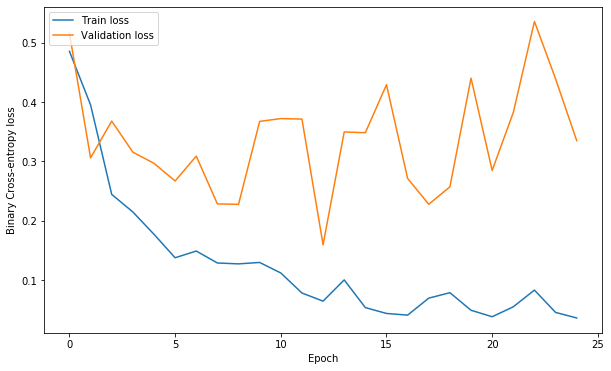

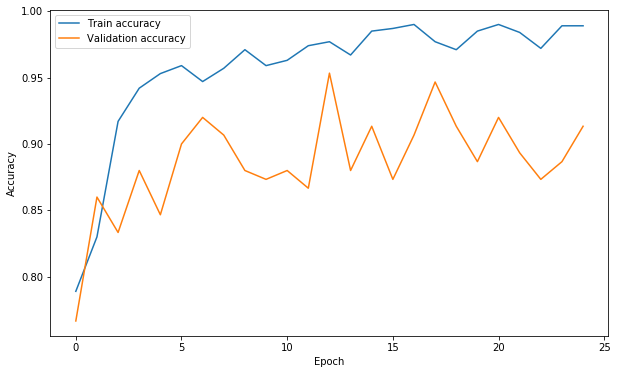

In [23]:
make_plots(results_2[0], results_2[1], results_2[2], results_2[3])

## Reweighting experiment 3

### Training: 100 positive (100 real) and 900 negative 
### Test: 75 positive (29 real + 46 generated) and 75 negative
### Hypervalidation: 5 real + 5 negative (hand-picked)

In [24]:
train_real, test_real = train_test_split(real_wakes, train_size = 100/142, test_size=0.2, random_state=RS)
train_gen, test_gen = train_test_split(generated_wakes, train_size = 0.087, test_size=0.046, random_state=RS)
train_neg, test_neg = train_test_split(not_wakes, train_size = 900/3000, test_size = 75/3000, random_state = RS)
test_pos = np.append(test_real, test_gen, axis = 0)
train_pos = train_real

In [25]:

test_x = np.append(test_pos, test_neg, axis = 0)
train_x = np.append(train_pos, train_neg, axis = 0)
test_pos_y = np.concatenate((np.ones(test_pos.shape[0]).reshape(-1,1), np.zeros(test_pos.shape[0]).reshape(-1,1)), axis = 1)
test_neg_y = np.concatenate((np.zeros(test_neg.shape[0]).reshape(-1,1), np.ones(test_neg.shape[0]).reshape(-1,1)), axis = 1)
train_pos_y = np.concatenate((np.ones(train_pos.shape[0]).reshape(-1,1), np.zeros(train_pos.shape[0]).reshape(-1,1)), axis = 1)
train_neg_y = np.concatenate((np.zeros(train_neg.shape[0]).reshape(-1,1), np.ones(train_neg.shape[0]).reshape(-1,1)), axis = 1)
test_y = np.append(test_pos_y, test_neg_y, axis = 0)
test_y_exp_1 = test_y
test_x_exp_1 = test_x
train_y = np.append(train_pos_y, train_neg_y, axis = 0)

In [26]:
train_dataset = TensorDataset(torch.Tensor(train_x), torch.Tensor(train_y))
test_dataset = TensorDataset(torch.Tensor(test_x), torch.Tensor(test_y))

In [27]:
tiny_X = torch.tensor(tiny_frames).float().to(device)
tiny_y = torch.tensor(tiny_labels).float().to(device)

In [28]:
resnet_1 = None
resnet_1 = mrn.ResNet18()
results_3 = train_weights(resnet_1, train_dataset, test_dataset, num_epochs = num_epochs, learning_rate=1e-4)

KeyboardInterrupt: 

In [ ]:
make_plots(results_3[0], results_3[1], results_3[2], results_3[3])

## Reweighting experiment 4

### Training: 50 positive (50 real) and 950 negative 
### Test: 75 positive (29 real + 46 generated) and 75 negative
### Hypervalidation: 5 real + 5 negative (hand-picked)

In [ ]:
train_real, test_real = train_test_split(real_wakes, train_size = 50/142, test_size=0.2, random_state=RS)
train_gen, test_gen = train_test_split(generated_wakes, train_size = 0.087, test_size=0.046, random_state=RS)
train_neg, test_neg = train_test_split(not_wakes, train_size = 950/3000, test_size = 75/3000, random_state = RS)
test_pos = np.append(test_real, test_gen, axis = 0)
train_pos = train_real

In [ ]:

test_x = np.append(test_pos, test_neg, axis = 0)
train_x = np.append(train_pos, train_neg, axis = 0)
test_pos_y = np.concatenate((np.ones(test_pos.shape[0]).reshape(-1,1), np.zeros(test_pos.shape[0]).reshape(-1,1)), axis = 1)
test_neg_y = np.concatenate((np.zeros(test_neg.shape[0]).reshape(-1,1), np.ones(test_neg.shape[0]).reshape(-1,1)), axis = 1)
train_pos_y = np.concatenate((np.ones(train_pos.shape[0]).reshape(-1,1), np.zeros(train_pos.shape[0]).reshape(-1,1)), axis = 1)
train_neg_y = np.concatenate((np.zeros(train_neg.shape[0]).reshape(-1,1), np.ones(train_neg.shape[0]).reshape(-1,1)), axis = 1)
test_y = np.append(test_pos_y, test_neg_y, axis = 0)
test_y_exp_1 = test_y
test_x_exp_1 = test_x
train_y = np.append(train_pos_y, train_neg_y, axis = 0)

In [ ]:
train_dataset = TensorDataset(torch.Tensor(train_x), torch.Tensor(train_y))
test_dataset = TensorDataset(torch.Tensor(test_x), torch.Tensor(test_y))

In [ ]:
tiny_X = torch.tensor(tiny_frames).float().to(device)
tiny_y = torch.tensor(tiny_labels).float().to(device)

In [ ]:
resnet_1 = None
resnet_1 = mrn.ResNet18()
results_4 = train_weights(resnet_1, train_dataset, test_dataset, num_epochs = num_epochs, learning_rate=1e-4)

In [ ]:
make_plots(results_4[0], results_4[1], results_4[2], results_4[3])

## Reweighting experiment 5

### Training: 25 positive (25 real) and 975 negative 
### Test: 75 positive (29 real + 46 generated) and 75 negative
### Hypervalidation: 5 real + 5 negative (hand-picked)

In [ ]:
train_real, test_real = train_test_split(real_wakes, train_size = 25/142, test_size=0.2, random_state=RS)
train_gen, test_gen = train_test_split(generated_wakes, train_size = 0.087, test_size=0.046, random_state=RS)
train_neg, test_neg = train_test_split(not_wakes, train_size = 975/3000, test_size = 75/3000, random_state = RS)
test_pos = np.append(test_real, test_gen, axis = 0)
train_pos = train_real

In [ ]:

test_x = np.append(test_pos, test_neg, axis = 0)
train_x = np.append(train_pos, train_neg, axis = 0)
test_pos_y = np.concatenate((np.ones(test_pos.shape[0]).reshape(-1,1), np.zeros(test_pos.shape[0]).reshape(-1,1)), axis = 1)
test_neg_y = np.concatenate((np.zeros(test_neg.shape[0]).reshape(-1,1), np.ones(test_neg.shape[0]).reshape(-1,1)), axis = 1)
train_pos_y = np.concatenate((np.ones(train_pos.shape[0]).reshape(-1,1), np.zeros(train_pos.shape[0]).reshape(-1,1)), axis = 1)
train_neg_y = np.concatenate((np.zeros(train_neg.shape[0]).reshape(-1,1), np.ones(train_neg.shape[0]).reshape(-1,1)), axis = 1)
test_y = np.append(test_pos_y, test_neg_y, axis = 0)
test_y_exp_1 = test_y
test_x_exp_1 = test_x
train_y = np.append(train_pos_y, train_neg_y, axis = 0)

In [ ]:
train_dataset = TensorDataset(torch.Tensor(train_x), torch.Tensor(train_y))
test_dataset = TensorDataset(torch.Tensor(test_x), torch.Tensor(test_y))

In [ ]:
tiny_X = torch.tensor(tiny_frames).float().to(device)
tiny_y = torch.tensor(tiny_labels).float().to(device)

In [ ]:
resnet_1 = None
resnet_1 = mrn.ResNet18()
results_5 = train_weights(resnet_1, train_dataset, test_dataset, num_epochs = num_epochs, learning_rate=1e-4)

In [ ]:
make_plots(results_5[0], results_5[1], results_5[2], results_5[3])

In [ ]:
1